In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
import numpy as np
from PIL import Image
import os
import string
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm 
tqdm().pandas()

C:\Users\admin\AppData\Local\Temp\ipykernel_7468\284391743.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [69]:
from sklearn.metrics import accuracy_score

In [70]:
def load_fp(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [71]:
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    return photos

In [73]:
train_im = load_photos(r"C:\Users\admin\ML-Project\Flickr8k_text\Flickr_8k.trainImages.txt")
print(len(train_im))

6000


In [74]:
val_im = load_photos(r"C:\Users\admin\ML-Project\Flickr8k_text\Flickr_8k.devImages.txt")
print(len(val_im))

1000


In [75]:
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        li = caption.split('\t')
        img, caption = li[0],li[1]
        
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
            
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions
descriptions = img_capt(r"C:\Users\admin\ML-Project\Flickr8k_text\Flickr8k.token.txt")
len(descriptions)

8092

In [76]:
def txt_clean(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            descp = img_caption.split()
            descp = [wrd.lower() for wrd in descp]
            descp = [wrd.translate(table) for wrd in descp]
            descp = [wrd for wrd in descp if(len(wrd)>1)]
            descp = [wrd for wrd in descp if(wrd.isalpha())]
            img_caption = ' '.join(descp)
            captions[img][i]= img_caption
    return captions


In [77]:
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

len(txt_vocab(descriptions))

9630

In [78]:
def save_descriptions(descriptions, filename):
    lines = list()
    clean_descriptions = txt_clean(descriptions)
    for key, desc_list in clean_descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    dataset_text = r"C:\Users\admin\ML-Project\Flickr8k_text"
    dataset_images = r"C:\Users\admin\ML-Project\Flicker8k_Dataset"
    filename = dataset_text + "/Flickr8k.token.txt"
    descriptions = img_capt(filename)
    print("Length of descriptions =" ,len(descriptions))
    vocabulary = txt_vocab(clean_descriptions)
    print("Length of vocabulary = ", len(vocabulary))
save_descriptions(descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [79]:

def load_clean_descriptions(filename, photos):   
    file = load_fp(filename)
    descriptions = {}
    for line in file.split("\n"):   
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


In [80]:
train_desc = load_clean_descriptions("descriptions.txt", train_im)


In [81]:
len(train_desc)

6000

In [82]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model

def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x

def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=5, strides=1)  
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=5, strides=1) 
    tensor = ReLU()(x)

    x = sep_bn(tensor, filters=128, kernel_size=5) 
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=5) 
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=5)  
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=5)  
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=5) 
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=5) 
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])
    return x

def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=5)  
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=5)  
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=5)
        x = ReLU()(x)
        tensor = Add()([tensor, x])
    return tensor

def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=5)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=5) 
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    x = sep_bn(x, filters=1536, kernel_size=5)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=5)
    x = GlobalAvgPool2D()(x)

    return x

input = Input(shape=(299, 299, 3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

cnn_model = Model(inputs=input, outputs=output)
cnn_model.summary()

In [ ]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [ ]:
features = extract_features(directory,cnn_model)
dump(features, open("features.p", "wb"))

In [72]:
feature = load(open("features.p", "rb"))
print(len(feature))

8091


In [84]:
train_fea = {k:feature[k] for k in train_im}
len(train_fea)

6000

In [85]:
val_fea = {k:feature[k] for k in val_im}
val_fea['2090545563_a4e66ec76b.jpg'].shape

(1, 2048)

In [86]:
val_desc = load_clean_descriptions("descriptions.txt", val_im)
len(val_desc)

1000

In [87]:
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [88]:
tokenizer_train = create_tokenizer(train_desc)

In [89]:
tokenizer_val = create_tokenizer(val_desc)

In [90]:
vocab_size = len(tokenizer_train.word_index) +1
vocab_size

7577

In [91]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
max_length = max_length(descriptions)
max_length 

32

In [92]:
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([inp_image, inp_seq], op_word)


In [93]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)


In [94]:
[a,b],c = next(data_generator(train_desc, train_fea, tokenizer_train, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [95]:
[a1,b1],c1 = next(data_generator(val_desc, val_fea, tokenizer_val, max_length))
a1.shape, b1.shape, c1.shape

((67, 2048), (67, 32), (67, 7577))

In [96]:
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm

In [97]:
from keras.utils import plot_model
from keras.layers import add
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(1,2048))
    fe1 = Dropout(0.2)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.2)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    return model

In [98]:
print('Dataset: ', len(train_im))
print('Descriptions: train=', len(train_desc))
print('Photos: train=', len(train_fea))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
steps = len(train_desc)
train_gen = data_generator(train_desc, train_fea, tokenizer_train, max_length)
val_gen = data_generator(val_desc, val_fea, tokenizer_val, max_length)
model.fit(train_gen, 
          epochs=5, 
          steps_per_epoch=len(train_desc), 
          verbose=1,
          validation_data=val_gen, 
          validation_steps=len(val_desc))
model.save("model1.h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 32)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1, 2048)]            0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 256)              1939712   ['input_11[0][0]']            
                                                                                                  
 dropout_2 (Dropout)         (None, 1, 2048)              0         ['input_10[0][0]

KeyboardInterrupt: 

In [99]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

In [101]:

def extract_features(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [102]:
from keras.applications.xception import Xception, preprocess_input
he=extract_features(img_path, cnn_model)
he.shape

1/1 [==============================] - 1s 1s/step


(1, 2048)

In [103]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [104]:

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None or word == 'end':
            break
        in_text += ' ' + word

    return in_text


1/1 [==============================] - 0s 318ms/step
start be with the shirt green be play


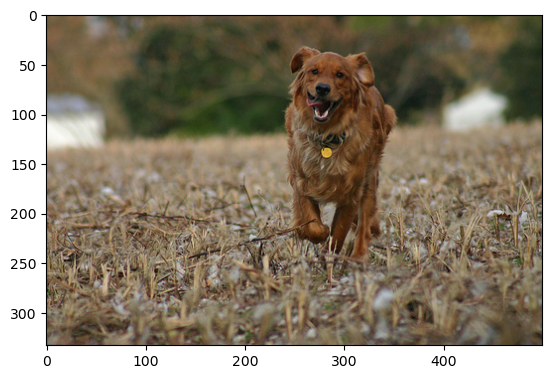

In [105]:
max_length = 32
img_path=r"C:\Users\admin\ML-Project\Flicker8k_Dataset\69189650_6687da7280.jpg"
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model1.h5')
photo = extract_features(img_path, cnn_model)
photo = np.expand_dims(photo, axis=0)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
plt.imshow(img)
print(description)
